In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm  
import tensorflow as tf

In [2]:
# Device configuration
device = ("cpu")
print(f'Using device: {device}')


Using device: cpu


In [3]:
# U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def block(in_channels, out_channels, kernel_size=3, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = block(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        # Decoder
        dec3 = self.up3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.final(dec1))


In [8]:
import torch
from torchvision import transforms
from PIL import Image

# Load the model
model = UNet().to(device)
model.load_state_dict(torch.load(r"coast.pth",map_location=torch.device('cpu')))
model.eval()
print("Model loaded successfully!")

    # Load and preprocess grayscale image
def load_and_preprocess_image(image_path):
    gray_image = Image.open(image_path).convert("L")
    gray_image = gray_image.resize((256, 256))

    transform = transforms.Compose([
        transforms.ToTensor(),  # No normalization
    ])

    gray_image = transform(gray_image)
    gray_image = gray_image.unsqueeze(0).to(device)
    return gray_image

def colorize_image(model, gray_image):
    with torch.no_grad():
        output = model(gray_image)
        output_image = output.squeeze(0).cpu()
        output_image = output_image.permute(1, 2, 0)
        output_image = output_image.clamp(0, 1)  # Ensure valid range

        output_image = Image.fromarray((output_image.numpy() * 255).astype('uint8'))
        return output_image





Model loaded successfully!


In [9]:
def show_images(original,gray_image, colorized):
    # Show original and colorized images side by side
    plt.figure(figsize=(15, 5))
    gray_image_display = gray_image.squeeze()
    
    plt.subplot(1, 3, 1)
    plt.title("Original Grayscale")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("gray scale")
    plt.imshow(gray_image_display, cmap='gray', vmin=0, vmax=1)

    plt.axis('off')

    plt.subplot(1,3, 3)
    plt.title("Colorized")
    plt.imshow(colorized)
    plt.axis('off')


    plt.show()



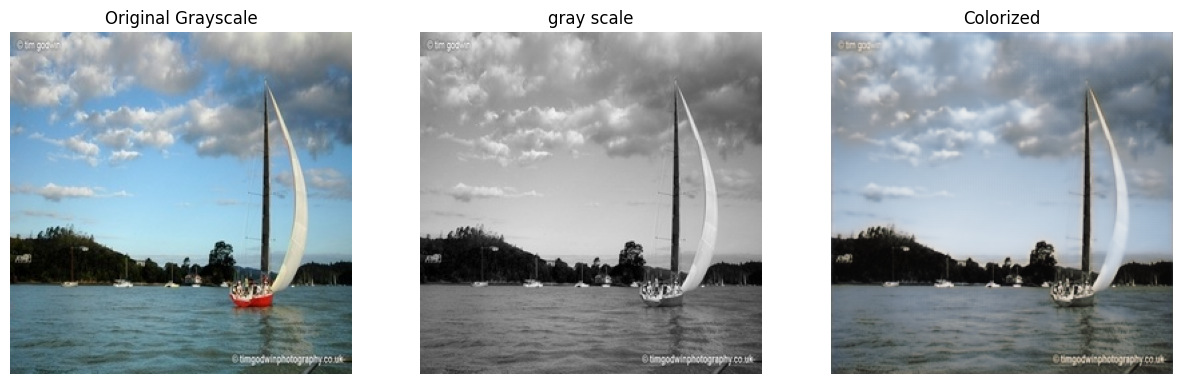

AttributeError: 'str' object has no attribute 'read'

In [10]:
import tensorflow as tf
import numpy as np
input_image = input("Enter image path or 'quit' to exit: ")
import cv2
while input_image != "quit":
    image_path = input_image[1:-1]

    # Load original image for display
    original_image = Image.open(image_path)
    original_image = cv2.resize(np.array(original_image),(256,256))



    # Preprocess image for model
    gray_image = load_and_preprocess_image(image_path)

    # Colorize image
    colorized_image = colorize_image(model, gray_image)
    
    # Show images
    show_images(original_image, gray_image, colorized_image)

    input_image = input("Enter image path or 'quit' to exit: ")

